<a href="https://colab.research.google.com/github/julia-e-ma/movies/blob/main/RandomMovieGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports and google drive authorization
from google.colab import auth
auth.authenticate_user()
import random
import pandas as pd
import gspread
from google.auth import default
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
import numpy as np
creds, _ = default()
gc = gspread.authorize(creds)

This notebook is based off of the movie spreadsheet. The spreadsheet contains a list of movies we'd like to watch together. If you can't decide on a movie, you can use this notebook to select parameters (genre, runtime, preferred actors, etc.) to decide on a movie to watch.

Add google form integration so we can update movies when watched and movies when we find a new one we want to watch.

In [2]:
# list of streaming platforms we both have
streaming_platforms = [
    'Netflix',
    'Hulu',
    'HBO Max',
    'Paramount+',
    'Disney+',
    'Roku',
    'Peacock'
]

In [13]:
# read in the existing spreadsheet
doc = gc.open('mega movie list')
worksheet = doc.sheet1
rows = worksheet.get_all_values()
movies = pd.DataFrame.from_records(rows)
movies.columns = movies.iloc[0]
movies = movies.drop(movies.index[0])

In [14]:
# this function is used to generate a normalized IMDb rating within the genre cluster
# requested feature because horror movies are usually bad and this will show movie rating within its genre for better comparison
def normalize(x):
  return (x-x.min())/(x.max()-x.min())
movies['IMDb'] = pd.to_numeric(movies['IMDb'], errors='coerce')
movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.apply(normalize)
movies.head()

<ipython-input-14-59c27efe66a7>:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.apply(normalize)


,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized
1,21,Drama,,2008,2h3m,,36%,6.8,,,Man,Drama,0.230769
2,9 to 5,Comedy,,1980,1h50m,,82%,6.9,Dolly Parton,,Old,Comedy,0.692308
3,A Haunting in Venice,Mystery,Crime,2023,1h47m,Hulu,75%,6.8,,,Horror,Mystery,0.000000
4,A Man Called Otto,Drama,Comedy,2022,2h6m,Netflix,69%,7.4,,,Drama,Drama,0.461538
5,Always Be My Maybe,Comedy,Romance,2019,1h41m,Netflix,89%,6.8,,,Teenage Girl,Comedy,0.653846


In [15]:
# this cell writes the normalized scores back to the spreadsheet
movies = movies.fillna(" ")
worksheet.update([movies.columns.values.tolist()] + movies.values.tolist())

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!A1:M97",
 'updatedRows': 97,
 'updatedColumns': 13,
 'updatedCells': 1261}

In [16]:
# get unique list of genres
genres = [movies['Primary Genre'].unique()]
genres.append(movies['Genre 2'].unique())
all_genres = [g.upper() for sublist in genres for g in sublist]
all_genres = set(all_genres)
all_genres.remove('')

# get unique list of notable actors
actors = movies['Noteworthy Actors'].unique()
actors = [a.split('/') for a in actors]
all_actors = [a.upper() for sublist in actors for a in sublist]
all_actors = set(all_actors)
all_actors.remove('')

# get unique list of notes/tags
notes = movies['Notes'].unique()
notes = [n.split('/') for n in notes]
all_notes = [n.upper() for sublist in notes for n in sublist]
all_notes = set(all_notes)
all_notes.remove('')

# get unique list of categories
categories = [movies['Category'].unique()]
all_categories = [c.upper() for sublist in categories for c in sublist]
all_categories = set(all_categories)

In [17]:
# convert duration to minutes
new = movies['Runtime'].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
movies['minutes'] = hour.astype(int)*60 + min.astype(int)

# convert year to int
movies['Year'] = movies['Year'].astype(int)

In [18]:
# get max values for sliders
max_runtime = movies['minutes'].max() + 10
max_year = movies['Year'].max()
min_year = movies['Year'].min()

# Movie Generator
1. Run the cell below
2. Use ctrl+click to select your options. (Note the columns. Your movie will be in one of the selected genres and must meet the duration/year/holiday criteria you select. If you select an actor, their movies will be given higher probability of being selected. The last column will EXCLUDE movies in that category)
3. Click Julia's apartment if we're in Julia's apartment (because she has Amazon Prime)
4. Run the following cell to print out the randomly selected movie.
5. Run the next cell to see the entire list of movies that met your criteria.

Rerun the next cell to reset the options

In [19]:
genre = widgets.SelectMultiple(
    options=list(all_genres),
    description='Genre',
    rows=10,
    disabled=False
)
apartment = widgets.ToggleButton(
    value=False,
    description='Julia\'s apartment',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Whose Apartment?',
    icon='check'
)
duration = widgets.IntRangeSlider(
    value=[0, 160],
    min=0,
    max=max_runtime,
    step=10,
    description='Duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
year = widgets.IntRangeSlider(
    value=[1990, 2024],
    min=min_year,
    max=max_year,
    step=1,
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
actor = widgets.SelectMultiple(
    options=list(all_actors),
    description='Actors',
    rows=10,
    disabled=False
)
category = widgets.SelectMultiple(
    options=list(all_categories),
    description='Category',
    rows=10,
    disabled=False
)
note = widgets.SelectMultiple(
    options=['HALLOWEEN','CHRISTMAS'],
    description='Holidays',
    rows=2,
    disabled=False
)
lbl1 = widgets.Label('Filter on these:')
lbl2 = widgets.Label('Add weight for these:')
lbl3 = widgets.Label('Exclude these:')
left_box = VBox([lbl1,genre,duration,year,note,apartment])
center_box = VBox([lbl2,actor])
right_box = VBox([lbl3,category])
HBox([left_box,center_box,right_box])

# TODO: Fix duration sort (duration in the spreadsheet is a str so it doesn't sort perfectly)

In [20]:
# add Prime to the list of streaming options if we're at Julia's apartment
if apartment.value:
  streaming_available = streaming_platforms
  streaming_available.append('Prime')
  streaming_available.append("Julia's TV")
else:
  streaming_available = streaming_platforms

# only search in selected genres and available platforms
selected_genres = "|".join(genre.value)
options = movies[movies['Primary Genre'].str.upper().str.contains(selected_genres) | movies['Genre 2'].str.upper().str.contains(selected_genres)]
avail_platforms = "|".join(streaming_available)
options = options[options['Streaming'].str.contains(avail_platforms)]

# filter out holiday movies unless selected
holiday = "|".join(note.value)
if len(holiday) < 1:
  holiday = 'HALLOWEEN|CHRISTMAS'
  options = options[~options['Notes'].str.upper().str.contains(holiday)]
else:
  options = options[options['Notes'].str.upper().str.contains(holiday)]

# filter out unwanted categories
if len(category.value) > 0:
  categories = "|".join(category.value)
  options = options[~options['Category'].str.upper().str.contains(categories)]

# limit by duration
options = options[options['minutes'] <= duration.value[1]]
options = options[options['minutes'] >= duration.value[0]]

# limit by year
options = options[options['Year'] <= year.value[1]]
options = options[options['Year'] >= year.value[0]]

# duplicate records where notable actors are present
# this will increase the likelihood of this movie being randomly chosen
selected_actors = "|".join(actor.value)
bonus_actors = options[options['Noteworthy Actors'].str.upper().str.contains(selected_actors)]
options = options.append(bonus_actors,ignore_index=True)


if len(options) < 1:
  print("There are no movies that meet this criteria")
else:
  print(options.sample())

0      Movie Primary Genre Genre 2  Year Runtime Streaming   RT IMDb  \
51  Rye Lane       Romance  Comedy  2023   1h22m      Hulu  98%  7.3   

0  Noteworthy Actors Notes      Category Genre Cluster Normalized  minutes  
51                          Teenage Girl        Comedy   0.846154       82  


<ipython-input-20-e86e89578013>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(bonus_actors,ignore_index=True)


In [21]:
print(options)

0                          Movie Primary Genre  Genre 2  Year Runtime  \
0           A Haunting in Venice       Mystery    Crime  2023   1h47m   
1              A Man Called Otto         Drama   Comedy  2022    2h6m   
2             Always Be My Maybe        Comedy  Romance  2019   1h41m   
3                      Amsterdam        Comedy  Mystery  2022   2h14m   
4   Confessions of a Shopaholic         Comedy  Romance  2009   1h45m   
..                           ...           ...      ...   ...     ...   
59                    The Wonder         Drama  Mystery  2022   1h43m   
60                 Thoroughbreds      Thriller   Comedy  2017   1h33m   
61                Transformers 2        Sci-Fi   Action  2009   2h30m   
62                    Underwater        Horror   Sci-Fi  2020   1h35m   
63                           Her       Romance   Sci-Fi  2013    2h6m   

0  Streaming   RT IMDb Noteworthy Actors Notes      Category Genre Cluster  \
0       Hulu  75%  6.8                       

(0.0, 10.0)

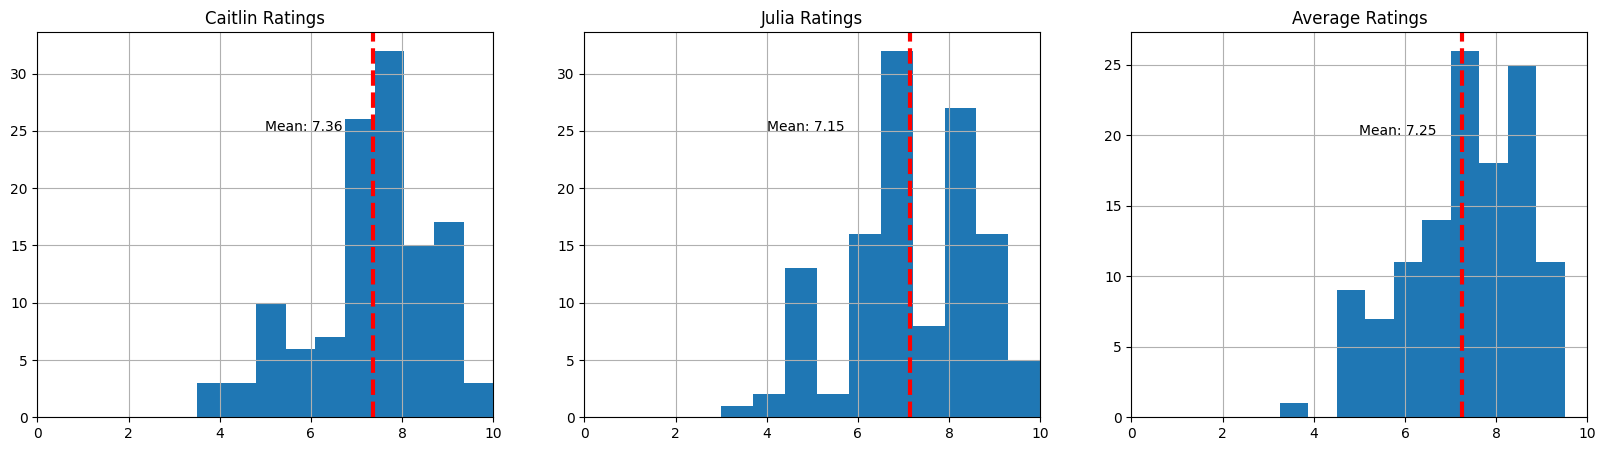

In [27]:
watched = doc.get_worksheet(1)
watch_history = watched.get_all_values()
mov = pd.DataFrame.from_records(watch_history)
mov = mov.iloc[1:]

# any blanks coerce to NaN, replace NaN with that column's average for the purposes of graphing
mov[2] = pd.to_numeric(mov[2], errors='coerce')
mov[3] = pd.to_numeric(mov[3], errors='coerce')
mov[4] = pd.to_numeric(mov[4], errors='coerce')
mov[2] = mov[2].fillna(mov[2].mean())
mov[3] = mov[3].fillna(mov[3].mean())
mov[4] = mov[4].fillna(mov[4].mean())

cc_ratings = mov[2].astype(float)
jm_ratings = mov[3].astype(float)
avg_ratings = mov[4].astype(float)

fig, axes = plt.subplots(1, 3, figsize = (20,5))
cc_ratings.hist(ax = axes[0])
jm_ratings.hist(ax = axes[1])
avg_ratings.hist(ax = axes[2])

axes[0].axvline(x=np.nanmean(cc_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[1].axvline(x=np.nanmean(jm_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[2].axvline(x=np.nanmean(avg_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[0].text(5, 25, 'Mean: {:.2f}'.format(np.nanmean(cc_ratings)))
axes[1].text(4, 25, 'Mean: {:.2f}'.format(np.nanmean(jm_ratings)))
axes[2].text(5, 20, 'Mean: {:.2f}'.format(np.nanmean(avg_ratings)))

axes[0].title.set_text('Caitlin Ratings')
axes[1].title.set_text('Julia Ratings')
axes[2].title.set_text('Average Ratings')

axes[0].set_xlim([0, 10])
axes[1].set_xlim([0, 10])
axes[2].set_xlim([0, 10])

In [28]:
import numpy as np
runtimes = pd.DataFrame(mov[8])
runtimes.head()
new = runtimes[8].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
runtimes['minutes'] = hour.astype(int)*60 + min.astype(int)
tot_min = sum(runtimes['minutes'])
tot_hr = np.floor(sum(runtimes['minutes']) / 60 )
tot_day = tot_min / (60*24)
print("We've seen " + str(tot_min) + " minutes of movies together, which is " + str(tot_hr) + " hours and " + str(sum(runtimes['minutes'])%60) + " minutes or " + str(tot_day) + " days")

We've seen 13816 minutes of movies together, which is 230.0 hours and 16 minutes or 9.594444444444445 days


In [29]:
from typing import AbstractSet
actors = mov[12]
actors = actors.str.split("/")

counts = {}
for acts in actors:
  if acts == []:
    pass
  else:
    for actor in acts:
      if actor in counts.keys():
        counts[actor] = counts[actor] + 1
      else:
        counts[actor] = 1

del counts['']
dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

{'Anne Hathaway': 5,
 'Kate Hudson': 4,
 'Jennifer Lawrence': 4,
 'Ryan Gosling': 4,
 'Florence Pugh': 4,
 'Zendaya': 3,
 'Emma Stone': 3,
 'Jamie Lee Curtis': 3,
 'Aubrey Plaza': 3,
 'Andrew Garfield': 2,
 'Sandra Bullock': 2,
 'James Marsden': 2,
 'Bradley Cooper': 2,
 'Sam Claflin': 2,
 'Maya Hawke': 2,
 'Margot Robbie': 2,
 'Taylor Swift': 2,
 'Taylor Lautner': 2,
 'Daisy Edgar-Jones': 2,
 'Sarah Michelle Gellar': 2,
 'Natasha Lyonne': 2,
 'Elisabeth Moss': 1,
 'Winona Ryder': 1,
 'Meryl Streep': 1,
 'Kristen Bell': 1,
 'Timothee Chalamet': 1,
 'Andy Samberg': 1,
 'Kristen Stewart': 1,
 'Alison Brie': 1}